# IMPORTS

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofweek, col

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder

import numpy as np
import matplotlib.pyplot as plt

# LOAD DATA

You can download the data at [Kaggle site](https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?select=2021.csv) or through the provided S3 bucket location.

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("FlightDelayPrediction").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

your 131072x1 screen size is bogus. expect trouble
23/12/01 23:39:36 WARN Utils: Your hostname, JeevsPC resolves to a loopback address: 127.0.1.1; using 172.18.163.150 instead (on interface eth0)
23/12/01 23:39:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/01 23:39:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file_path = "2021.csv"
data_2021 = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
target_col = "DEP_DELAY"

# DATA ANALYSIS

In [5]:
data_2021.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = tru

In [6]:
# Show a sample of the data
print("\nSample of Data 2021:")
data_2021.show(5, truncate=False)


Sample of Data 2021:


+----------+------------+--------+---------+------+----------------------+----+----------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+-------+--------+------+
|FL_DATE   |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY           |DEST|DEST_CITY             |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|FL_YEAR|FL_MONTH|FL_DAY|
+----------+------------+--------+---------+------+----------------------+----+----------------------+------------+--------+---------+--------+----------+---------+-------+------------+-

In [7]:
# Summary statistics
print("\nSummary Statistics for Data 2021:")
data_2021.describe().show()


Summary Statistics for Data 2021:


+-------+------------+------------------+------------------+-------+------------+-------+------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+--------------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-------------------+-----------------------+--------------------+-----------------+------------------+
|summary|AIRLINE_CODE|          DOT_CODE|         FL_NUMBER| ORIGIN| ORIGIN_CITY|   DEST|   DEST_CITY|      CRS_DEP_TIME|          DEP_TIME|        DEP_DELAY|          TAXI_OUT|        WHEELS_OFF|         WHEELS_ON|          TAXI_IN|     CRS_ARR_TIME|          ARR_TIME|        ARR_DELAY|           CANCELLED|CANCELLATION_CODE|            DIVERTED|  CRS_ELAPSED_TIME|      ELAPSED_TIME|          AIR_TIME|         DIST

In [8]:
# Check for missing values
print("Missing Values in Data 2021:")
for df_col in data_2021.columns:
    missing_count = data_2021.filter(data_2021[df_col].isNull()).count()
    print(f"{df_col}: {missing_count} missing values")

Missing Values in Data 2021:


FL_DATE: 0 missing values


AIRLINE_CODE: 0 missing values


DOT_CODE: 0 missing values


FL_NUMBER: 0 missing values


ORIGIN: 0 missing values


ORIGIN_CITY: 0 missing values


DEST: 0 missing values


DEST_CITY: 0 missing values


CRS_DEP_TIME: 0 missing values


DEP_TIME: 100656 missing values


DEP_DELAY: 100744 missing values


TAXI_OUT: 102461 missing values


WHEELS_OFF: 102461 missing values


WHEELS_ON: 104433 missing values


TAXI_IN: 104433 missing values


CRS_ARR_TIME: 0 missing values


ARR_TIME: 104416 missing values


ARR_DELAY: 117178 missing values


CANCELLED: 0 missing values


CANCELLATION_CODE: 0 missing values


DIVERTED: 0 missing values


CRS_ELAPSED_TIME: 1 missing values


ELAPSED_TIME: 117178 missing values


AIR_TIME: 117178 missing values


DISTANCE: 0 missing values


DELAY_DUE_CARRIER: 4985066 missing values


DELAY_DUE_WEATHER: 4985066 missing values


DELAY_DUE_NAS: 4985066 missing values


DELAY_DUE_SECURITY: 4985066 missing values


DELAY_DUE_LATE_AIRCRAFT: 4985066 missing values


FL_YEAR: 0 missing values


FL_MONTH: 0 missing values


FL_DAY: 0 missing values


# DATA PREPROCESSING / FEATURE SELECTION

In [95]:
# Sort data by FL_DATE column in ascending order
preprocessed_data_2021 = data_2021.sort("FL_DATE")

# Remove rows that have cancelled flights
preprocessed_data_2021 = preprocessed_data_2021.filter(data_2021.CANCELLED == 0)

# Add column for day of the week, based on FL_DATE
preprocessed_data_2021 = preprocessed_data_2021.withColumn("DAY_OF_WEEK", dayofweek(col("FL_DATE")))

In [96]:
# Keep these columns in a new dataframe (Domain Knowledge Feature Selection)
preprocessed_data_2021 = preprocessed_data_2021.select("FL_YEAR", "FL_MONTH", "FL_DAY", "DAY_OF_WEEK", "AIRLINE_CODE", "ORIGIN", "DEST", "CRS_DEP_TIME", target_col)

preprocessed_data_2021 = preprocessed_data_2021.dropna()

In [97]:
preprocessed_data_2021.count()

5892337

In [13]:
# Convert ORIGIN to OneHotEncoded vector
indexer = StringIndexer(inputCols=['AIRLINE_CODE', 'ORIGIN', 'DEST'], outputCols=['INDEXED_AIRLINE_CODE', 'INDEXED_ORIGIN', 'INDEXED_DEST'])
preprocessed_data_2021 = indexer.fit(preprocessed_data_2021).transform(preprocessed_data_2021)

encoder = OneHotEncoder(inputCols=['INDEXED_AIRLINE_CODE', 'INDEXED_ORIGIN', 'INDEXED_DEST'], outputCols=['ONEHOT_AIRLINE_CODE', 'ONEHOT_ORIGIN', 'ONEHOT_DEST'])
preprocessed_data_2021 = encoder.fit(preprocessed_data_2021).transform(preprocessed_data_2021)

In [14]:
# Keep these onehot encoded columns only
preprocessed_data_2021 = preprocessed_data_2021.select("FL_YEAR", "FL_MONTH", "FL_DAY", "DAY_OF_WEEK", 'ONEHOT_AIRLINE_CODE', 'ONEHOT_ORIGIN', 'ONEHOT_DEST', target_col)

In [15]:
# Take only first 10,000 rows, due to limited CPU power. If you have a better CPU or running this on AWS, you can comment this line out.
preprocessed_data_2021 = preprocessed_data_2021.limit(10000)

In [16]:
preprocessed_data_2021.show(5, truncate=False)

+-------+--------+------+-----------+-------------------+-----------------+-----------------+---------+
|FL_YEAR|FL_MONTH|FL_DAY|DAY_OF_WEEK|ONEHOT_AIRLINE_CODE|ONEHOT_ORIGIN    |ONEHOT_DEST      |DEP_DELAY|
+-------+--------+------+-----------+-------------------+-----------------+-----------------+---------+
|2021   |1       |1     |6          |(16,[6],[1.0])     |(370,[10],[1.0]) |(370,[76],[1.0]) |0.0      |
|2021   |1       |1     |6          |(16,[6],[1.0])     |(370,[10],[1.0]) |(370,[97],[1.0]) |-2.0     |
|2021   |1       |1     |6          |(16,[6],[1.0])     |(370,[139],[1.0])|(370,[10],[1.0]) |-4.0     |
|2021   |1       |1     |6          |(16,[6],[1.0])     |(370,[97],[1.0]) |(370,[21],[1.0]) |-5.0     |
|2021   |1       |1     |6          |(16,[6],[1.0])     |(370,[10],[1.0]) |(370,[148],[1.0])|14.0     |
+-------+--------+------+-----------+-------------------+-----------------+-----------------+---------+
only showing top 5 rows



In [17]:
preprocessed_data_2021.describe().show()

+-------+-------+--------+------+-----------+------------------+
|summary|FL_YEAR|FL_MONTH|FL_DAY|DAY_OF_WEEK|         DEP_DELAY|
+-------+-------+--------+------+-----------+------------------+
|  count|  10000|   10000| 10000|      10000|             10000|
|   mean| 2021.0|     1.0|   1.0|        6.0|            5.6873|
| stddev|    0.0|     0.0|   0.0|        0.0|43.635083599806194|
|    min|   2021|       1|     1|          6|             -39.0|
|    max|   2021|       1|     1|          6|            1779.0|
+-------+-------+--------+------+-----------+------------------+



In [18]:
# Vectorization
feature_cols = list(set(preprocessed_data_2021.columns) - set([target_col])) # All columns except ARR_DELAY (target variable)
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
vectorized_data_2021 = vector_assembler.transform(preprocessed_data_2021)

In [19]:
vectorized_data_2021.select("features", target_col).show(5, truncate=False)

+---------------------------------------------------------------+---------+
|features                                                       |DEP_DELAY|
+---------------------------------------------------------------+---------+
|(760,[0,1,78,378,388,399,759],[1.0,6.0,1.0,1.0,2021.0,1.0,1.0])|0.0      |
|(760,[0,1,48,383,388,408,759],[1.0,6.0,1.0,1.0,2021.0,1.0,1.0])|-5.0     |
|(760,[0,1,99,378,388,399,759],[1.0,6.0,1.0,1.0,2021.0,1.0,1.0])|-2.0     |
|(760,[0,1,7,383,388,397,759],[1.0,6.0,1.0,1.0,2021.0,1.0,1.0]) |3.0      |
|(760,[0,1,12,378,388,528,759],[1.0,6.0,1.0,1.0,2021.0,1.0,1.0])|-4.0     |
+---------------------------------------------------------------+---------+
only showing top 5 rows



In [20]:
# Standardization
scaler = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
scaled_data_2021 = scaler.fit(vectorized_data_2021).transform(vectorized_data_2021)

In [21]:
scaled_data_2021.select("scaled_features", target_col).show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# TRAIN/TEST SPLIT

In [22]:
# Define train/test split percentage
train_percent = 0.6
val_percent = 0.2
test_percent = 0.2

# Calculate the split indices
count = scaled_data_2021.count()
train_index = int(train_percent * count)
val_index = train_index + int(val_percent * count)

# Split the data into training, validation, and testing sets
train_data = scaled_data_2021.limit(train_index)
val_data = scaled_data_2021.limit(val_index).subtract(train_data)
test_data = scaled_data_2021.subtract(train_data).subtract(val_data)

# Extract train, validation, test sets from the dataset
X_train, y_train = train_data.select('scaled_features'), train_data.select(target_col)
X_val, y_val = val_data.select('scaled_features'), val_data.select(target_col)
X_test, y_test = test_data.select('scaled_features'), test_data.select(target_col)

# MODEL BUILDING

In [46]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.clip_value = 0.01
        
        # Initialize weights for input to hidden layer and hidden to output layer
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden = np.array([0.1] * hidden_size)
        self.bias_output = np.array([0.1] * output_size)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)
    
    def clip_gradients(self, gradients):
        return np.clip(gradients, -self.clip_value, self.clip_value)

    def forward(self, x):
        self.hidden_state = self.leaky_relu(x.dot(self.weights_input_hidden) + self.bias_hidden) 
        output = self.hidden_state.dot(self.weights_hidden_output) + self.bias_output 
        return output

    def backward(self, x, output, target):
        loss_gradient = 2 * (output - target)  # Mean Squared Error loss gradient
        hidden_state_gradient = self.weights_hidden_output.dot(loss_gradient)
        
        # Clip gradients before updating weights
        hidden_state_gradient_clipped = self.clip_gradients(hidden_state_gradient)
        loss_gradient_clipped = self.clip_gradients(loss_gradient)
    
        self.weights_input_hidden -= self.learning_rate * np.outer(x, hidden_state_gradient_clipped)
        self.weights_hidden_output -= self.learning_rate * np.outer(self.hidden_state, loss_gradient_clipped)
        self.bias_hidden -= self.learning_rate * hidden_state_gradient_clipped
        self.bias_output -= self.learning_rate * loss_gradient_clipped
        
    def predict(self, x):
        self.hidden_state = self.leaky_relu(x.dot(self.weights_input_hidden) + self.bias_hidden)
        output = self.hidden_state.dot(self.weights_hidden_output) + self.bias_output
        return output

In [24]:
def mean_squared_error(y_true, y_pred):
    mse = np.mean(np.square(y_true - y_pred))
    return mse

# TRAINING

In [25]:
X_train_np, y_train_np = X_train.collect(), y_train.collect()

In [26]:
X_val_np, y_val_np = X_val.collect(), y_val.collect()

In [100]:
# Parameters
learning_rate = 0.001
epochs = 10
hidden_size = 5

input_size = len(X_train_np[0][0])
output_size = 1
rnn_model = SimpleRNN(input_size, hidden_size, output_size, learning_rate)

train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}:')
    
    # Training evaluation
    train_loss = 0
    for i in range(len(X_train_np)):
        input_train = np.array(X_train_np[i][0])
        target_train = y_train_np[i][0]
        output_train = rnn_model.forward(input_train)
        rnn_model.backward(input_train, output_train, target_train)
        train_loss += mean_squared_error(target_train, output_train)
    avg_train_loss = train_loss / len(X_train_np)
    train_losses.append(avg_train_loss)
    print(f'Train Loss: {avg_train_loss}', end=' | ')
    
    # Validation evaluation
    val_loss = 0
    for i in range(len(X_val_np)):
        input_val = np.array(X_val_np[i][0])
        target_val = y_val_np[i][0]
        output_val = rnn_model.forward(input_val)
        val_loss += mean_squared_error(target_val, output_val)
    average_val_loss = val_loss / len(X_val_np)
    val_losses.append(average_val_loss)
    print(f'Validation Loss: {average_val_loss}\n')

Epoch 1:
Train Loss: 2673.1177753024904 | Validation Loss: 1905.630718028355

Epoch 2:
Train Loss: 2379.4355231581144 | Validation Loss: 1737.42254422084

Epoch 3:
Train Loss: 2187.9676817375944 | Validation Loss: 1620.3163235129077

Epoch 4:
Train Loss: 2081.3714951650063 | Validation Loss: 1558.1428232108615

Epoch 5:
Train Loss: 2039.8320297157509 | Validation Loss: 1536.9923805197911

Epoch 6:
Train Loss: 2030.077129694019 | Validation Loss: 1533.3744968995525

Epoch 7:
Train Loss: 2030.1038778818547 | Validation Loss: 1533.6485930391227

Epoch 8:
Train Loss: 2030.708008937599 | Validation Loss: 1533.6568408376272

Epoch 9:
Train Loss: 2030.772991205551 | Validation Loss: 1533.822634665814

Epoch 10:
Train Loss: 2030.865287768684 | Validation Loss: 1533.9703925553758



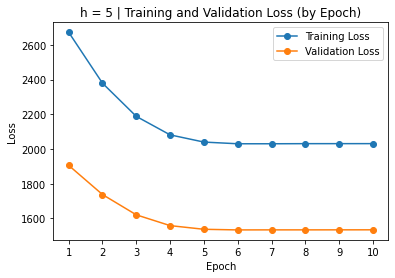

In [101]:
def plot_loss(train_loss, val_loss, hidden_size):
    # Create an array for the number of epochs, e.g., [1, 2, 3, ...]
    epochs = np.arange(1, len(train_loss) + 1)

    # Plot training accuracy and validation accuracy on the same graph
    plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-')

    # Set axis labels and a legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    # Display the plot
    plt.xticks(np.arange(1, len(train_loss) + 1, step=1))
    plt.title(f'h = {hidden_size} | Training and Validation Loss (by Epoch)')
    plt.show()
    
plot_loss(train_losses, val_losses, hidden_size)

# EVALUATION

In [83]:
X_test_np, y_test_np = X_test.collect(), y_test.collect()

In [93]:
# Make predictions on a new set of data
preds = []

for i in range(len(X_test_np)):
    input = np.array(X_test_np[i][0])
    output = rnn_model.predict(input)
    preds.append(output)

# Convert predictions to a NumPy array
preds = np.array(preds)

In [94]:
mse_value = mean_squared_error(y_test_np, preds)
print(f"Test Mean Squared Error: {mse_value}")
print(f"Test Root Mean Squared Error: {np.sqrt(mse_value)}")

Test Mean Squared Error: 2422.083332156909
Test Root Mean Squared Error: 49.21466582388739
